In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pymc as pm

In [ ]:
def load_data(filestem):
    signatrues_scores_dir = Path("../data/ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized/signature_scores_scaled/").resolve()
    assert signatrues_scores_dir.exists() and signatrues_scores_dir.is_dir(), signatrues_scores_dir
    icir_dir = Path("../lair/ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized").resolve()
    assert icir_dir.exists() and icir_dir.is_dir(), icir_dir

    signature_scores = pd.read_csv(signatrues_scores_dir / "{}.csv".format(filestem), index_col=0)
    assert len(signature_scores) > 0
    
    icir_data = ad.read_h5ad(icir_dir / "{}.h5ad".format(filestem))
    response = icir_data.obs.response
    assert len(response) > 0
    
    X = signature_scores.values
    y = (response.values == "R").astype(int)
    
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42+5)
    assert len(y_test) > 0
    assert len(y_train) > 0
    assert len(np.unique(y_test)) > 1
    assert len(np.unique(y_train)) > 1
    return X_train, X_test, y_train, y_test, idx_train, idx_test

def define_model(X_train, y_train):
    group_idx = np.concatenate([np.repeat(i, n) for i, n in enumerate([8, 8, 11, 2])])
    n_major_features = len(np.unique(group_idx))
    n_features = len(group_idx)
    
    x_shared = pm.Data("x_shared", X_train)
    y_shared = pm.Data("y_shared", y_train)
    # Population-level hyperpriors for the 4 Major Features
    mu_major = pm.Normal("mu_major", mu=0, sigma=10, shape=n_major_features)
    sigma_major = pm.HalfNormal("sigma_major", sigma=0.01, shape=n_major_features)
    # Sub-feature coefficients (Regularized by their group)
    beta = pm.Normal("beta",
                     mu=mu_major[group_idx],
                     sigma=sigma_major[group_idx],
                     shape=n_features)
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    p = pm.Deterministic("p", pm.math.sigmoid(alpha + pm.math.dot(x_shared, beta)))
    # Likelihood (Observed data)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_shared)

def print_model_eval(X, y, trace):
    pm.set_data({
        "x_shared": X,
        "y_shared": y
    })
    post_pred = pm.sample_posterior_predictive(trace)
    y_pred = np.round(post_pred.posterior_predictive.y_obs.mean(dim=["draw", "chain"]).values)
    print(f"Accuracy: {accuracy_score(y, y_pred)}")
    print(classification_report(y, y_pred))

def plot_box_and_hist(ax, X, y, trace):
    pm.set_data({
        "x_shared": X,
        "y_shared": y
    })
    post_pred = pm.sample_posterior_predictive(trace)
    y_pred = post_pred.posterior_predictive.y_obs.mean(dim=["draw", "chain"]).values
    unique_groups = np.unique(y)
    data_to_plot = [y_pred[y == g] for g in unique_groups]
    ax[0].boxplot(data_to_plot, labels=unique_groups)
    ax[0].scatter(y + 1, y_pred)
    ax[0].set_ylim(0, 1)
    unique_groups = np.unique(y)
    data_to_plot = [y_pred[y == g] for g in unique_groups]
    bins = np.linspace(0, 1, 10)
    ax[1].hist(data_to_plot[0], alpha=0.5, bins=bins)
    ax[1].hist(data_to_plot[1], alpha=0.5, bins=bins)
    ax[1].set_xlim(0, 1)


def main():
    icir_path = Path("../lair/ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized")
    for file in icir_path.glob("*.h5ad"):
        print(100*"=")
        print(file)
        try:
            X_train, X_test, y_train, y_test, idx_train, idx_test = load_data(file.stem)
        except AssertionError as e:
            print(f"Skipping {file.stem} due to {e}")
            continue
        hierachical_binary_model = pm.Model()
        with hierachical_binary_model:
            define_model(X_train, y_train)
            trace = pm.sample(1_00, tune=1000, chains=4)
        
            print_model_eval(X_train, y_train, trace)
            print_model_eval(X_test, y_test, trace)
        
            fig, ax = plt.subplots(2, 2, figsize=(10,8))
            plot_box_and_hist(ax.T[0], X_train, y_train, trace)
            plot_box_and_hist(ax.T[1], X_test, y_test, trace)
            plt.title(file.stem)
            plt.tight_layout()
            plt.savefig(f"../plots/hierachical_binary_model/{file.stem}.png")
            plt.show()

def main():
    icir_path = Path("../lair/ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized")
    for file in icir_path.glob("Gide.h5ad"):
        print(file)
        try:
            X_train, X_test, y_train, y_test, idx_train, idx_test = load_data(file.stem)
            X = np.concatenate([X_train, X_test])
            y = np.concatenate([y_train, y_test])
        except AssertionError as e:
            print(f"Skipping {file.stem} due to {e}")
            continue
        hierachical_binary_model = pm.Model()
        with hierachical_binary_model:
            define_model(X, y)
            trace = pm.sample(100, tune=1000, chains=4)
    return hierachical_binary_model, trace, X, y

hierachical_binary_model, trace, X, y = main()

In [ ]:
sigma = trace.posterior.p.std(dim=["draw", "chain"]).values
mu = trace.posterior.p.mean(dim=["draw", "chain"]).values

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
for i, color in zip([0, 1], ["red", "green"]):
    print(i, color)
    ax.scatter(mu[y==i], np.log(sigma)[y==i], color=color)
plt.xlabel("Predicted Probability")
plt.ylabel("Log(Standard Deviation)")
plt.legend(["Negative", "Positive"])
plt.title("Predicted Probability vs Log(Standard Deviation)")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

response = ["response" if x==1 else "non-response" for x in y]
# 1. Create a dummy dataset
np.random.seed(42)
data = pd.DataFrame({
    'x': mu,
    'y': np.log(sigma),
    'group': response
})

# 2. Set the style
sns.set_theme(style="white")
plt.figure(figsize=(4, 4))

# 3. Plot the Density Background (KDE)
# 'fill=True' creates the background effect, 'alpha' makes it subtle
sns.kdeplot(
    data=data, x="x", y="y", hue="group",
    fill=True, alpha=0.3, palette="viridis", levels=7
)

# 4. Layer the Scatter Plot on top
sns.scatterplot(
    data=data, x="x", y="y", hue="group", 
    palette="viridis", edgecolor="white", s=50
)

plt.xlabel(r"Mean Predicted Probability $\mu_p$")
plt.ylabel(r"Log Standard Deviation $\log(\sigma_p)$")
plt.legend(
    title="Response Type", 
    loc="lower left", 
    # bbox_to_anchor=(1, 1), 
    title_fontsize=12, 
    fontsize=10
)
plt.xlim(0, 1)
plt.ylim(-3.6, -1.3)
plt.title("Response Predictions")
plt.tight_layout()
plt.savefig("../plots/response_predictions.svg")
plt.show()

In [ ]:

# 1. Generate the graph object
gv_graph = pm.model_to_graphviz(hierachical_binary_model)

# 2. Save it to disk
# This creates 'my_model_structure.png'
gv_graph.render(filename='../plots/hierachical_model.svg', format='svg', cleanup=True)

In [ ]:
df = data[["x", "group"]]
sns.boxplot(df, y="x", x="group")

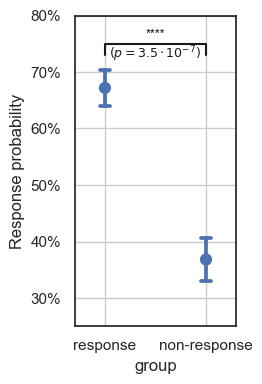

In [124]:
import matplotlib.ticker as mtick
plt.figure(figsize=(2.7,4))
ax = sns.pointplot(data=df, x="group", y="x", capsize=0.1, join=False, errorbar='se')
plt.ylabel("Response probability")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
plt.grid()

# 2. Define the bracket coordinates
x1, x2 = 0, 1   # The x-positions of your two points
y, h, col = 0.75, 0.02, 'k'  # y: height of line, h: height of the "staple" ends

# 3. Draw the line
# We draw a line from (x1, y-h) -> (x1, y) -> (x2, y) -> (x2, y-h)
plt.plot([x1, x1, x2, x2], [y-h, y, y, y-h], lw=1.5, c=col)

# 4. Add the asterisk
plt.text((x1+x2)*.5, y-0.035, "****\n" r"$(p=3.5\cdot 10^{-7})$", ha='center', va='bottom', color=col, fontsize=9)

plt.ylim(0.25, 0.8) # Adjust y-limit to make room for the bracket
plt.xlim(-0.3, 1.3)
plt.tight_layout()
plt.savefig("../plots/mean-response.svg")
plt.show()

In [ ]:
import pandas as pd
from scipy import stats

# 1. Split the data into two groups
group_a = df[df['group'] == 'response']['x']
group_b = df[df['group'] == 'non-response']['x']

# 2. Check for Normality (Shapiro-Wilk Test)
# If p > 0.05, the data is likely normal
shapiro_a = stats.shapiro(group_a).pvalue
shapiro_b = stats.shapiro(group_b).pvalue

if shapiro_a > 0.05 and shapiro_b > 0.05:
    # 3a. Use T-Test (Parametric)
    t_stat, p_val = stats.ttest_ind(group_a, group_b)
    print(f"T-test p-value: {p_val}")
else:
    # 3b. Use Mann-Whitney U (Non-parametric)
    u_stat, p_val = stats.mannwhitneyu(group_a, group_b)
    print(f"Mann-Whitney U p-value: {p_val}")

# 4. Interpretation
if p_val < 0.05:
    print("Result: Statistically Significant (Reject Null Hypothesis)")
else:
    print("Result: Not Statistically Significant")

In [ ]:
group_a

In [ ]:
df

In [ ]:
pd.concat(mean)

In [ ]:
df_top_low = df.loc[(df["x"].quantile(0.25) <= df["x"]) & (df["x"] <= df["x"].quantile(0.75))]
sns.violinplot(df_top_low, y="x", x="group")

In [ ]:
df["x"].quantile(0.25) <= df["x"]